In [ ]:
!pip install node2vec

In [ ]:
import pandas as pd
import networkx as nx

# Load SELinuxRealTE.csv
df_selinux = pd.read_csv('/content/Data/SELinuxRealTE.csv')

# Load attributes.csv
df_attributes = pd.read_csv('/content/Data/attributes.csv')

# Load objectclass.csv
df_objectclass = pd.read_csv('/content/Data/objectclass.csv')


In [ ]:
# Create empty directed graph for SELinux policy
G_selinux = nx.DiGraph()

# Add edges from SELinuxRealTE.csv
for _, row in df_selinux.iterrows():
    source = row['Source']
    target = row['Target']
    obj_class = row['ObjectClass']
    permission = row['Permission']
    G_selinux.add_edge(source, target, object_class=obj_class, permission=permission)

In [ ]:
# Create attribute graph
G_attributes = nx.Graph()

# Add nodes and edges from attributes.csv
for _, row in df_attributes.iterrows():
    context = row['1']
    attributes = row['2'].split(', ')
    G_attributes.add_node(context)
    for attr in attributes:
        G_attributes.add_edge(context, attr)

In [ ]:
# Create objectclass graph
G_objectclass = nx.Graph()

# Add nodes and edges from objectclass.csv
for _, row in df_objectclass.iterrows():
    obj_class = row['Name']
    permissions = row['Permissions'].split(', ')
    G_objectclass.add_node(obj_class)
    for perm in permissions:
        G_objectclass.add_edge(obj_class, perm)

In [ ]:
from node2vec import Node2Vec

# Convert SELinux policy graph to node2vec format
node2vec_selinux = Node2Vec(G_selinux, dimensions=64, walk_length=30, num_walks=200, workers=4)


Computing transition probabilities:   0%|          | 0/4721 [00:00<?, ?it/s]

In [ ]:
# Embed nodes
model_selinux = node2vec_selinux.fit(window=10, min_count=1, batch_words=4)


In [ ]:
# Get node embeddings
embeddings_selinux = {node: model_selinux.wv[node] for node in G_selinux.nodes}


In [ ]:
# Similarly, apply node2vec to attribute and objectclass graphs
node2vec_attributes = Node2Vec(G_attributes, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_attributes = node2vec_attributes.fit(window=10, min_count=1, batch_words=4)
embeddings_attributes = {node: model_attributes.wv[node] for node in G_attributes.nodes}

node2vec_objectclass = Node2Vec(G_objectclass, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_objectclass = node2vec_objectclass.fit(window=10, min_count=1, batch_words=4)
embeddings_objectclass = {node: model_objectclass.wv[node] for node in G_objectclass.nodes}

Computing transition probabilities:   0%|          | 0/5234 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/410 [00:00<?, ?it/s]

In [ ]:
from sklearn.ensemble import IsolationForest

# Convert embeddings to a format suitable for anomaly detection
X_selinux = [embeddings_selinux[node] for node in G_selinux.nodes]
X_attributes = [embeddings_attributes[node] for node in G_attributes.nodes]
X_objectclass = [embeddings_objectclass[node] for node in G_objectclass.nodes]

In [ ]:
# Fit Isolation Forest for anomaly detection
detector_selinux = IsolationForest(contamination=0.1)
detector_selinux.fit(X_selinux)
anomalies_selinux = detector_selinux.predict(X_selinux)

detector_attributes = IsolationForest(contamination=0.1)
detector_attributes.fit(X_attributes)
anomalies_attributes = detector_attributes.predict(X_attributes)

detector_objectclass = IsolationForest(contamination=0.1)
detector_objectclass.fit(X_objectclass)
anomalies_objectclass = detector_objectclass.predict(X_objectclass)

In [ ]:
# Print anomalies (nodes identified as anomalies)
print("Anomalies in SELinux Policy Graph:")
print([node for node, anomaly in zip(G_selinux.nodes, anomalies_selinux) if anomaly == -1])

print("Anomalies in Attribute Graph:")
print([node for node, anomaly in zip(G_attributes.nodes, anomalies_attributes) if anomaly == -1])

print("Anomalies in ObjectClass Graph:")
print([node for node, anomaly in zip(G_objectclass.nodes, anomalies_objectclass) if anomaly == -1])

Anomalies in SELinux Policy Graph:
['lib_t', 'var_lock_t', 'usr_t', 'antivirus_db_t', 'login_exec_t', 'file_type', 'httpd_log_t', 'var_yp_t', 'user_home_dir_t', 'spamass_milter_data_t', 'systemd_logind_var_run_t', 'virt_etc_t', 'var_lib_t', 'httpd_sys_content_t', 'glusterd_var_lib_t', 'sysctl_t', 'mozilla_exec_t', 'mysqld_etc_t', 'pingd_etc_t', 'telepathy_idle_tmp_t', 'kdump_t', 'install_exec_t', 'initrc_var_run_t', 'mock_build_exec_t', 'dhcpd_tmp_t', 'postfix_master_t', 'cyrus_var_lib_t', 'rsync_t', 'rsync_data_t', 'shell_exec_t', 'dhcp_etc_t', 'man_t', 'container_var_lib_t', 'sysctl_fs_t', 'NetworkManager_var_run_t', 'pppd_etc_rw_t', 'named_filetrans_domain', 'fonts_cache_t', 'afs_config_t', 'proc_t', 'cardmgr_var_run_t', 'ctdbd_tmp_t', 'pki_tomcat_t', 'rpm_var_cache_t', 'httpd_user_ra_content_t', 'neutron_initrc_exec_t', 'mock_var_lib_t', 'minidlna_t', 'xdm_var_run_t', 'mysqld_db_t', 'lvm_etc_t', 'mtrr_device_t', 'httpd_config_t', 'public_content_t', 'boltd_var_lib_t', 'systemd_pass

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


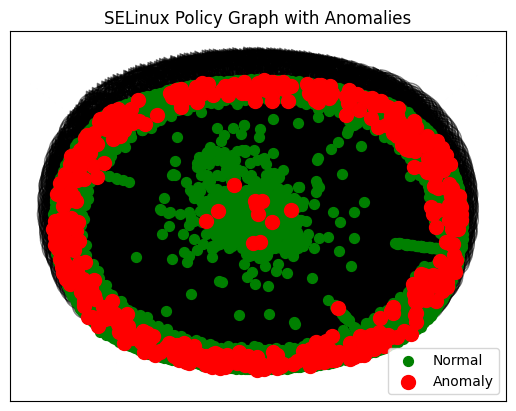

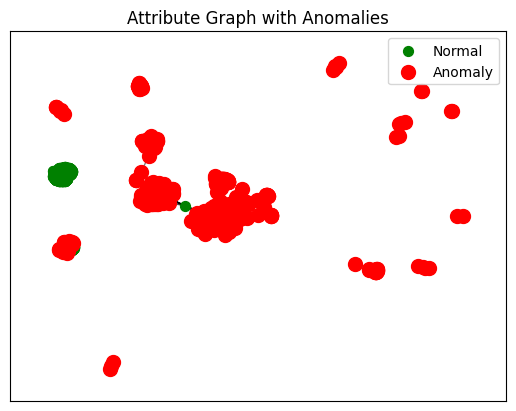

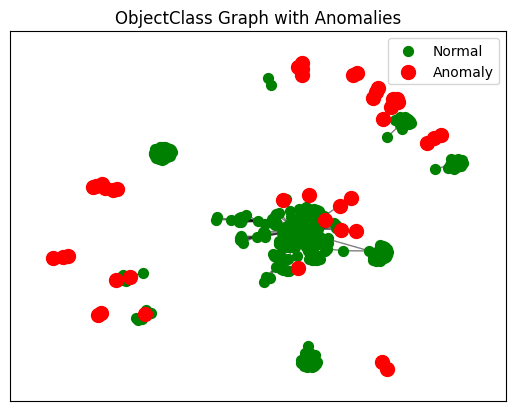

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualization function without labeling the nodes
def visualize_graph_with_anomalies_no_labels(G, anomalies, title):
    pos = nx.spring_layout(G)
    anomaly_nodes = [node for node, anomaly in zip(G.nodes, anomalies) if anomaly == -1]
    normal_nodes = [node for node, anomaly in zip(G.nodes, anomalies) if anomaly != -1]
    nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_color='green', node_size=50, label='Normal')
    nx.draw_networkx_nodes(G, pos, nodelist=anomaly_nodes, node_color='red', node_size=100, label='Anomaly')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize anomalies in SELinux Policy Graph
visualize_graph_with_anomalies_no_labels(G_selinux, anomalies_selinux, 'SELinux Policy Graph with Anomalies')

# Visualize anomalies in Attribute Graph
visualize_graph_with_anomalies_no_labels(G_attributes, anomalies_attributes, 'Attribute Graph with Anomalies')

# Visualize anomalies in ObjectClass Graph
visualize_graph_with_anomalies_no_labels(G_objectclass, anomalies_objectclass, 'ObjectClass Graph with Anomalies')


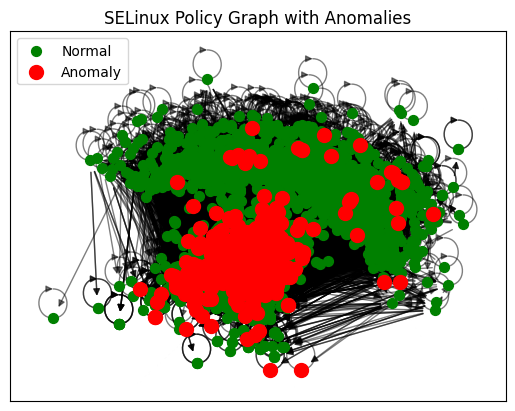

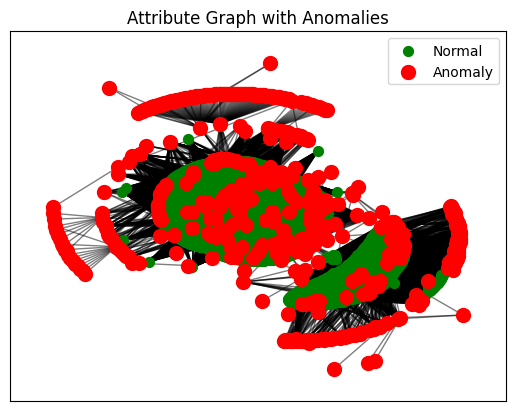

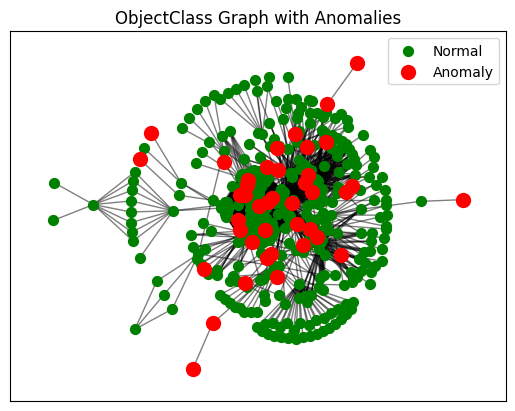

In [ ]:
# def visualize_graph_with_anomalies_no_labels(G, anomalies, title):
#     pos = nx.kamada_kawai_layout(G)  # Use Kamada-Kawai layout
#     anomaly_nodes = [node for node, anomaly in zip(G.nodes, anomalies) if anomaly == -1]
#     normal_nodes = [node for node, anomaly in zip(G.nodes, anomalies) if anomaly != -1]
#     nx.draw_networkx_nodes(G, pos, nodelist=normal_nodes, node_color='green', node_size=50, label='Normal')
#     nx.draw_networkx_nodes(G, pos, nodelist=anomaly_nodes, node_color='red', node_size=100, label='Anomaly')
#     nx.draw_networkx_edges(G, pos, alpha=0.5)
#     plt.title(title)
#     plt.legend()
#     plt.show()

# # Visualize anomalies in SELinux Policy Graph
# visualize_graph_with_anomalies_no_labels(G_selinux, anomalies_selinux, 'SELinux Policy Graph with Anomalies')

# # Visualize anomalies in Attribute Graph
# visualize_graph_with_anomalies_no_labels(G_attributes, anomalies_attributes, 'Attribute Graph with Anomalies')

# # Visualize anomalies in ObjectClass Graph
# visualize_graph_with_anomalies_no_labels(G_objectclass, anomalies_objectclass, 'ObjectClass Graph with Anomalies')
